The first cell is necessary due to current setup. In the future, basecamp may be a pip package, so that's not necessary.
However, to configure matplotlib to work with jupyter will stay necessary. 

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'path/to/everest-basecamp')

In [2]:
path_prefix = './tpred_v7_20230417/'

ML-developer part
---------------------------
Below is the a tensorflow code to develop a small DNN inference application using already trained coefficients. Afterwards the model is exported to the community standard ONNX. 

In [3]:

# pure tensorflow-2 design
# input are 10 x NN coefficient sets
# input data is temporary fixed 

import tensorflow as tf
import numpy as np
from datetime import datetime


NI = 17   # kernel vector input size
L1 = 16   # layer 1 internal size
L2 = 8    # layer 2 internal size
NO = 4    # kernel vector output size
M = 10    # number of models


def read_coefficients(): 
   import pickle
   import glob
   import re

   # NN coefficients data read-only storage
   W1 = np.zeros((M,NI,L1))
   B1 = np.zeros((M,L1))
   W2 = np.zeros((M,L1,L2))
   B2 = np.zeros((M,L2))
   W3 = np.zeros((M,L2,NO))
   B3 = np.zeros((M,NO))

   # reading all coefficient files _coeffs_xxx.pkl (pickle)
   cflist = [f for f in glob.glob(path_prefix + "*.pkl")]
   for filename in cflist:
      match =  re.search('_coeffs_(.+?).pkl', filename)
      rid = 0
      if match: rid = int(match.group(1))
      if rid < 0 or rid >= M: continue   # ignore models oo range
      print("reading dataset", rid)

      with open(filename, 'rb') as f:
         coeffs = pickle.load(f)
         #print(coeffs[0])
         W1[rid] = np.array(coeffs[0])
         B1[rid] = np.array(coeffs[1])
         W2[rid] = np.array(coeffs[2])
         B2[rid] = np.array(coeffs[3])
         W3[rid] = np.array(coeffs[4])
         B3[rid] = np.array(coeffs[5])

   W1coeffs = tf.constant(W1)
   B1coeffs = tf.constant(B1)
   W2coeffs = tf.constant(W2)
   B2coeffs = tf.constant(B2)
   W3coeffs = tf.constant(W3)
   B3coeffs = tf.constant(B3)
   #print(B1coeffs)
   return W1coeffs, B1coeffs, W2coeffs, B2coeffs, W3coeffs, B3coeffs


@tf.function
def actual_nn(x, w1, b1, w2, b2, w3, b3):
    r1 = tf.add( tf.matmul(x,w1), b1)
    r1 = tf.nn.relu(r1)
    r2 = tf.add( tf.matmul(r1,w2), b2)
    r2 = tf.nn.relu(r2)
    r3 = tf.add( tf.matmul(r2,w3), b3)
    return r3


def nnff(rid, x, W1coeffs, B1coeffs, W2coeffs, B2coeffs, W3coeffs, B3coeffs):
    x = x.reshape(1,NI)
    w1 = W1coeffs[rid]
    b1 = B1coeffs[rid]
    w2 = W2coeffs[rid]
    b2 = B2coeffs[rid]
    w3 = W3coeffs[rid]
    b3 = B3coeffs[rid]
    return actual_nn(x, w1, b1, w2, b2, w3, b3)


N = 10000

# temporary data vector inputs
N = 10
sel = np.array([0,1,2,3,4,5,6,7,8,9])
x = np.random.rand(M,NI)
testvin = [ 0.67583333, 0.00979945, 0.04920436, 0.13759263, 0.06469057, 0.08390333,
 0.16429468, 0.20028039, 0.20028039, 0.03327256, 0.05749056, 0.04966954,
 0.00140196, 0.0622435, 0.16673623, 0.19927899, 0.16282796]
testvin = np.array(testvin)

# reading data
W1,B1,W2,B2,W3,C3 = read_coefficients()

# prediction
start_time = datetime.now()
Y_out = []
for i in range(N):
    if i%1000 == 0: print("inference", i)
    index = i%M
    road_id = sel[index]
    vin = x[index]
    vin = testvin # temporary
    y_pred = nnff(road_id, vin, W1,B1,W2,B2,W3,C3)
    y_numpy = y_pred.numpy()[0]
    Y_out.append((road_id, y_numpy))

duration = datetime.now() - start_time
print("inference duration", duration.total_seconds())
#print(Y_out)
for item in Y_out: print(item)

2023-05-09 11:12:09.077624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 11:12:09.157262: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 11:12:09.157967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 11:12:10.079763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


reading dataset 1
reading dataset 2
reading dataset 3
reading dataset 4
reading dataset 5
reading dataset 6
reading dataset 7
reading dataset 8
reading dataset 9
reading dataset 0
inference 0
inference duration 0.086709
(0, array([0.2180444 , 0.19374896, 0.24366782, 0.39151645]))
(1, array([0.24330026, 0.17156633, 0.25695502, 0.29858127]))
(2, array([0.22866731, 0.16934106, 0.24396827, 0.3189122 ]))
(3, array([0.23047104, 0.16520517, 0.26473684, 0.33145031]))
(4, array([0.23326643, 0.20355088, 0.24804351, 0.30533612]))
(5, array([0.23196099, 0.19477799, 0.25422379, 0.32153531]))
(6, array([0.21177996, 0.23426783, 0.31939614, 0.37410296]))
(7, array([0.25760845, 0.1760157 , 0.25493291, 0.27164131]))
(8, array([0.2539872 , 0.21236475, 0.23549768, 0.34869378]))
(9, array([0.1940175 , 0.16873814, 0.28301809, 0.29957538]))


In the next step, we export the `actual_nn` function to onnx, because DOSA (everest ML infernce flow) requires an ONNX input. Therefore, the NN function must be decorated with `@tf.function` above.

In [4]:
import tf2onnx

# tf2onnx needs the shape of the input and weights
example_input = np.random.rand(1,17)
w1 = W1[0]
b1 = B1[0]
w2 = W2[0]
b2 = B2[0]
w3 = W3[0]
b3 = C3[0] 

model_proto, external_tensor_storage = tf2onnx.convert.from_function(actual_nn,
                                                                     input_signature=(x, w1, b1, w2, b2, w3, b3))

with open("./tmp.onnx", 'wb') as f:
    f.write(model_proto.SerializeToString())

2023-05-09 11:12:11.421466: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-09 11:12:11.421588: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-09 11:12:11.442153: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-09 11:12:11.442269: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [5]:
! ls -l | grep tmp.onnx

-rw-rw-r--. 1 ngl ngl     579 May  9 11:12 tmp.onnx


Now, we start using Everest-basecamp

In [6]:
from ebc import basecamp


# batch_size = 10000
batch_size = 1
precision = 8

emli = basecamp.ml_inference
emli.set_constraints(app_name="EVEREST traffic prediction v1",
                     onnx_input_name='x',
                     input_shape=[batch_size, 17],
                     input_size_t=precision,
                     bitwidth_of_activations=precision,
                     bitwidth_of_weights=precision,
                     batch_size=batch_size,
                     target_throughput=5000,  # batch_size inferences per second
                     arch_gen_strategy='throughput'
                     )

# set the path to emit the DOSA applicaiton.
#  it will contain the software runtime (for some platforms, e.g. cloudFPGA)
#  as well as the FPGA design files that needed to be synthesized, place and routed (e.g. on a dedicated server)
emli.set_output_path('/tmp/dosa_build/etp_v1')
# set the path to the exported ONNX model
emli.set_model_path('onnx', './tmp.onnx')

After defining the flow, we start the compilation...

/home/ngl/gitrepos/cloudFPGA/DOSA
[DOSA:config:INFO] Allowing a degredation of the throughput of 0.1 from the targeted throughput.
[DOSA:build:INFO] Not deleting existing content in output dir.
DOSA: Building OSGs, communication and device libraries...
	...done.

DOSA: Parsing constraints...
[DOSA:ConstraintParsing:WARNING] [NOT YET IMPLEMENTED] Custom fixed point fractional bits will be ignored, due to unclear encoding.
	...done.

DOSA: Importing ONNX...
	...done.

DOSA: Executing TVM optimization passes...
	...done.

DOSA: Generating high-level architecture...
[DOSA:OICALC:INFO] overwriting dtypes of function (input) with DosaDtype.int8 (orig: float64).
[DOSA:OICALC:INFO] overwriting dtypes of function FN_0001 with DosaDtype.int8 (orig: float64).
[DOSA:OICALC:INFO] overwriting dtypes of function FN_0002 with DosaDtype.int8 (orig: float64).
[DOSA:OICALC:INFO] overwriting dtypes of function FN_0003 with DosaDtype.int8 (orig: float64).
[DOSA:OICALC:INFO] overwriting dtypes of function F

/home/ngl/gitrepos/cloudFPGA/DOSA/dimidium/lib/plot_throughput.py:112: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(xlist[0], xlist[-1])


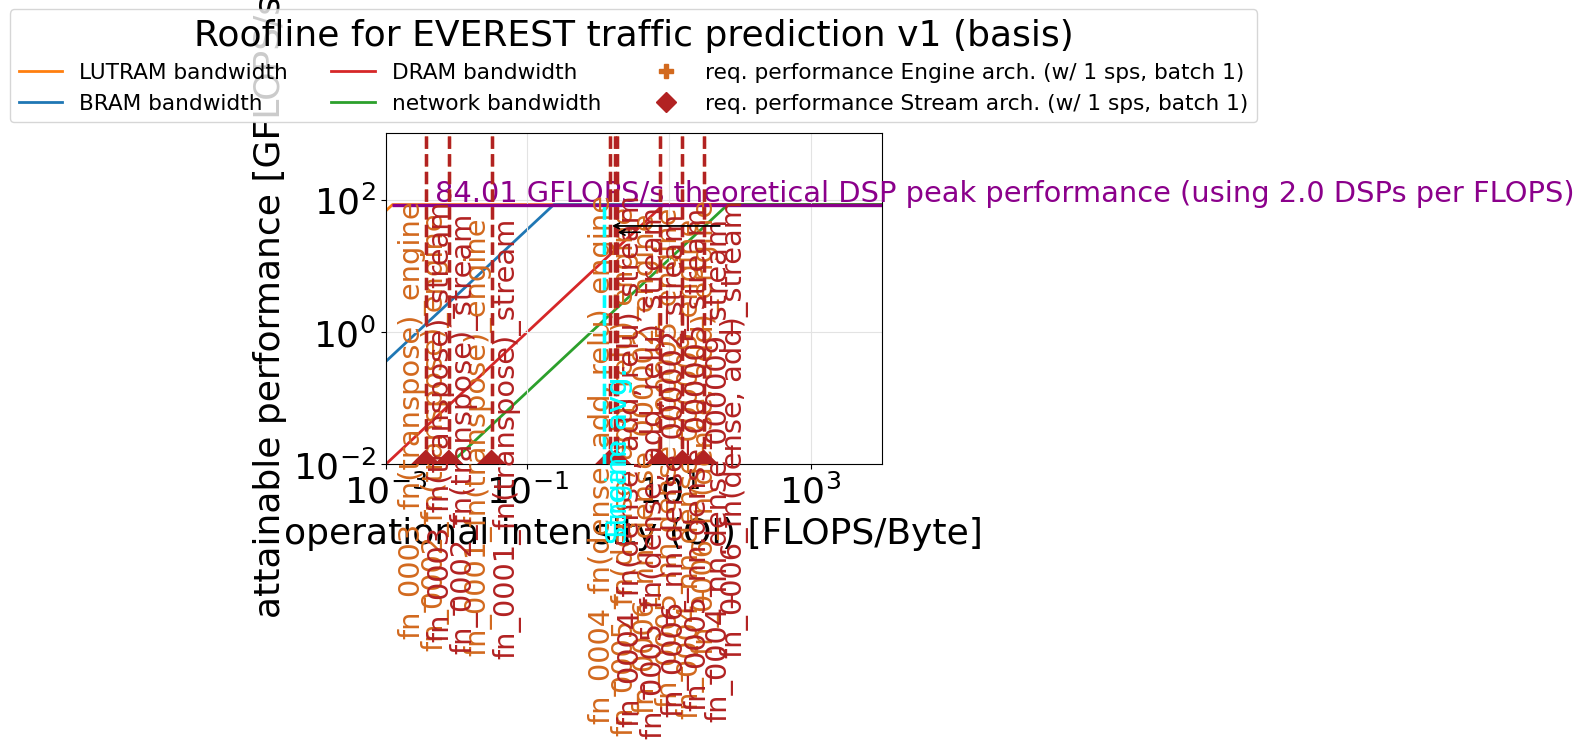

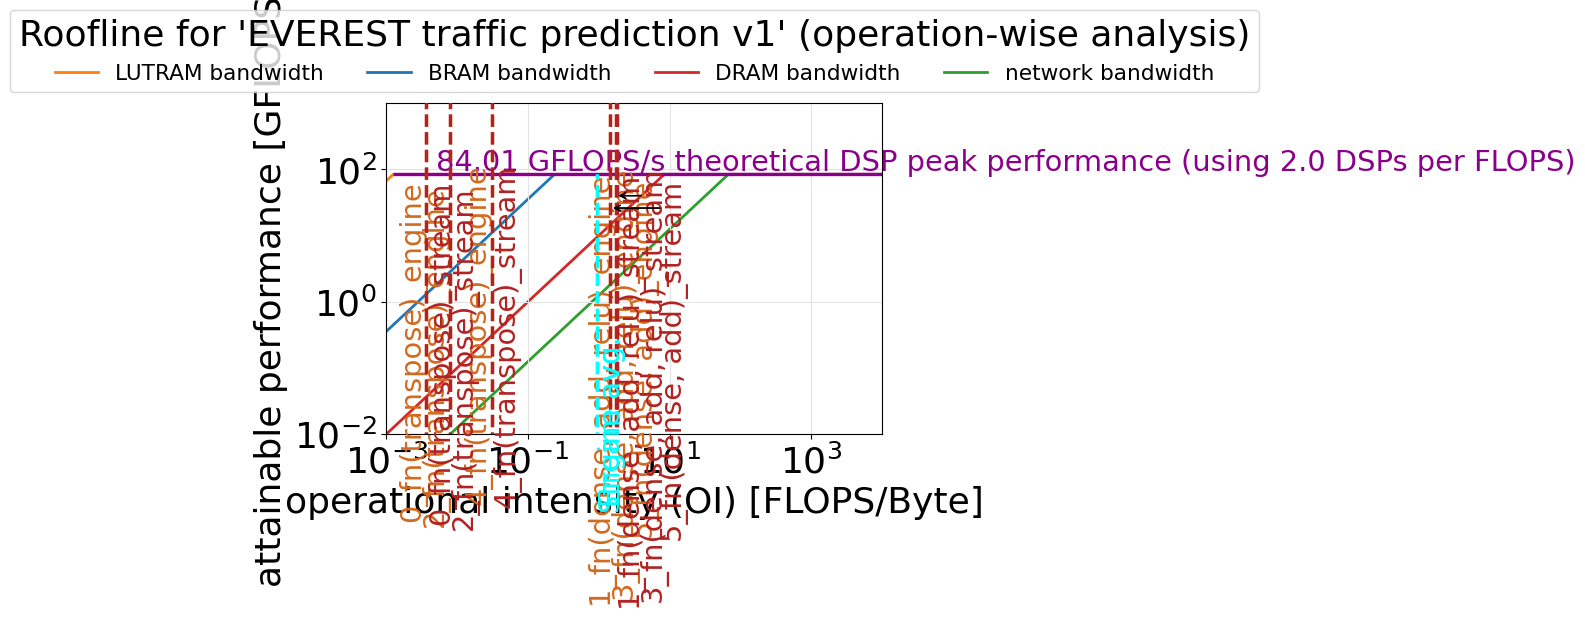

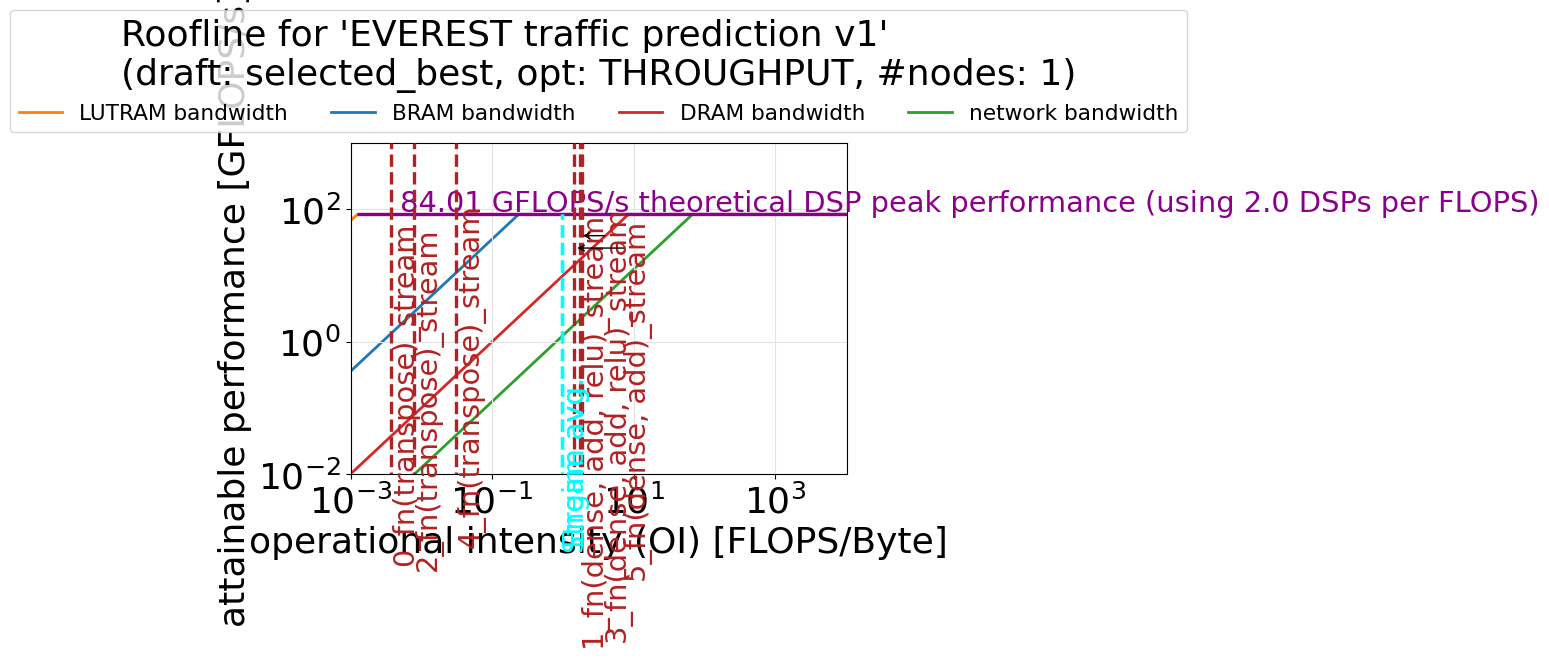

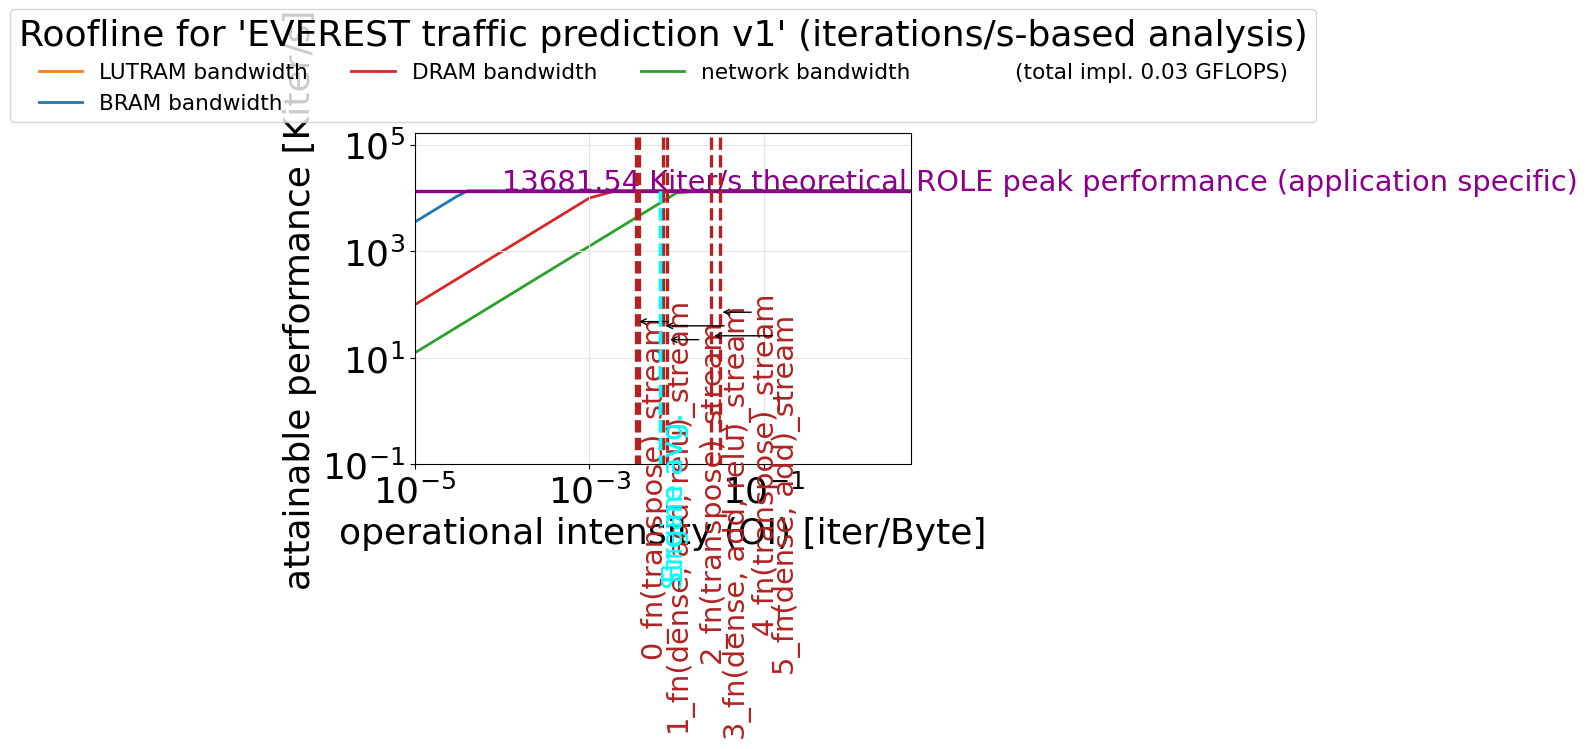

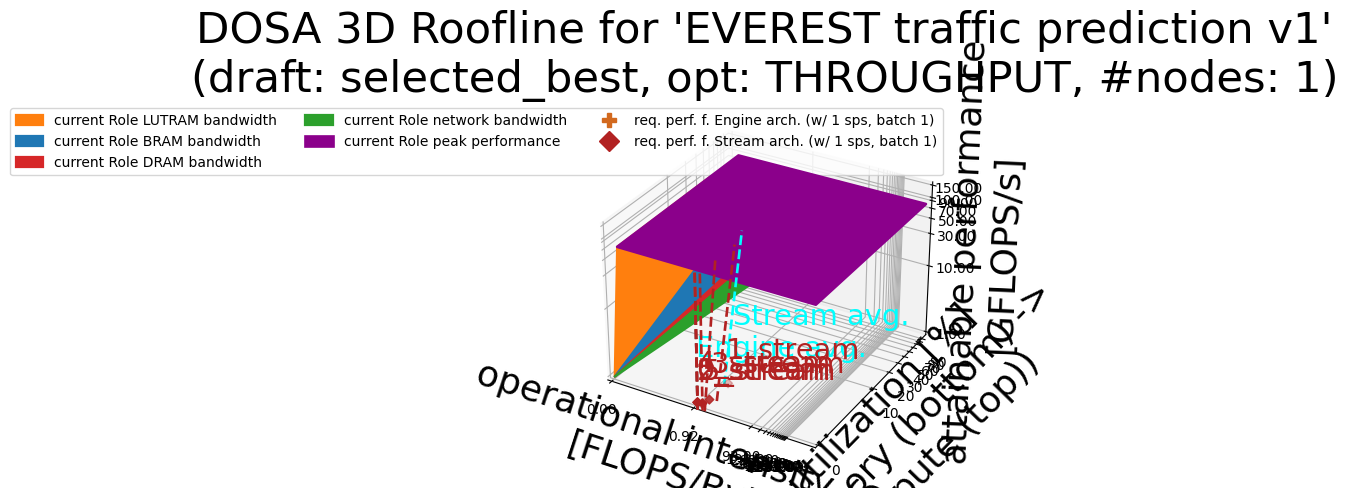

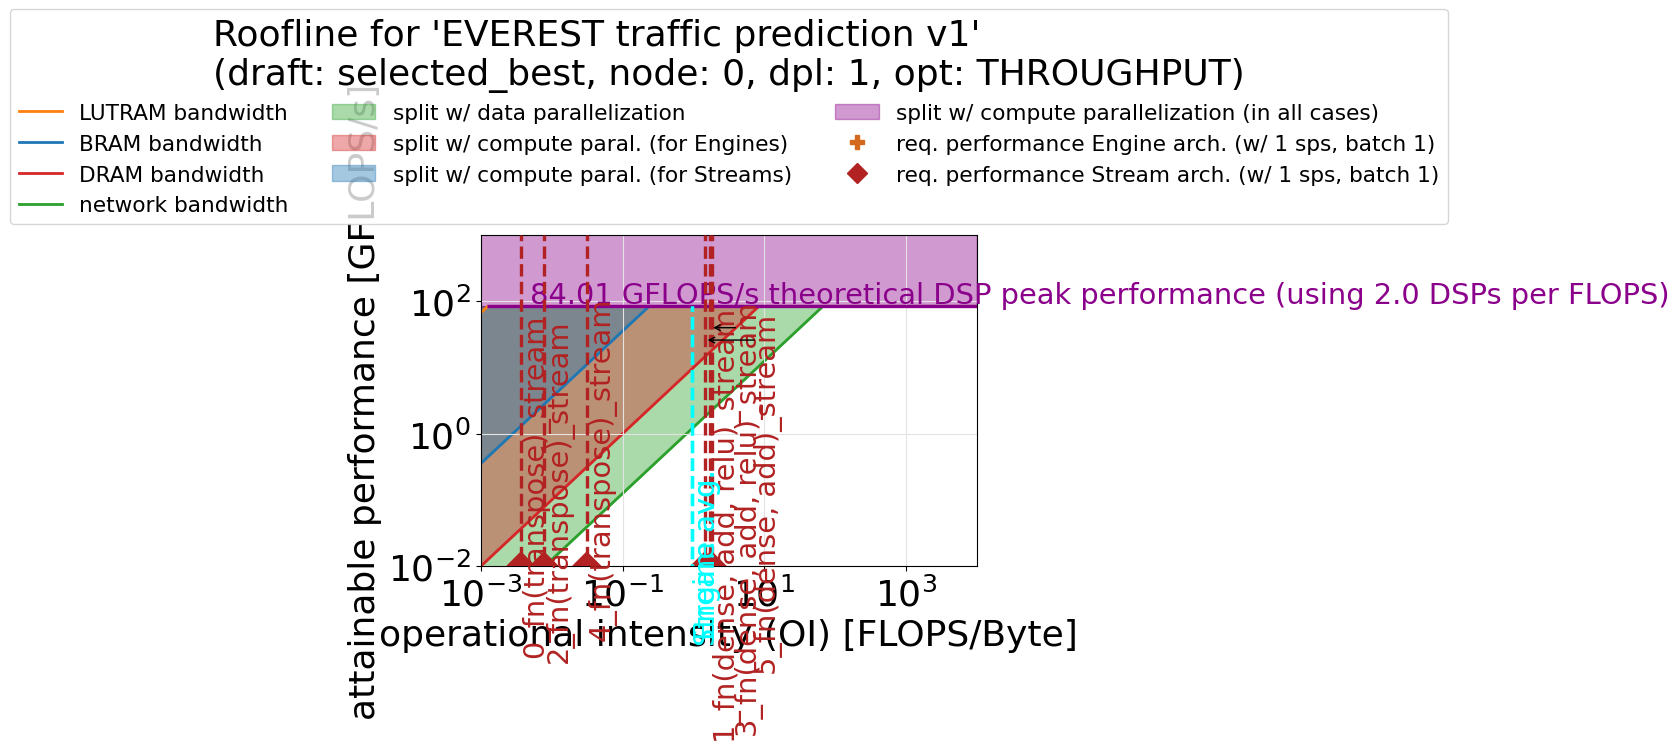

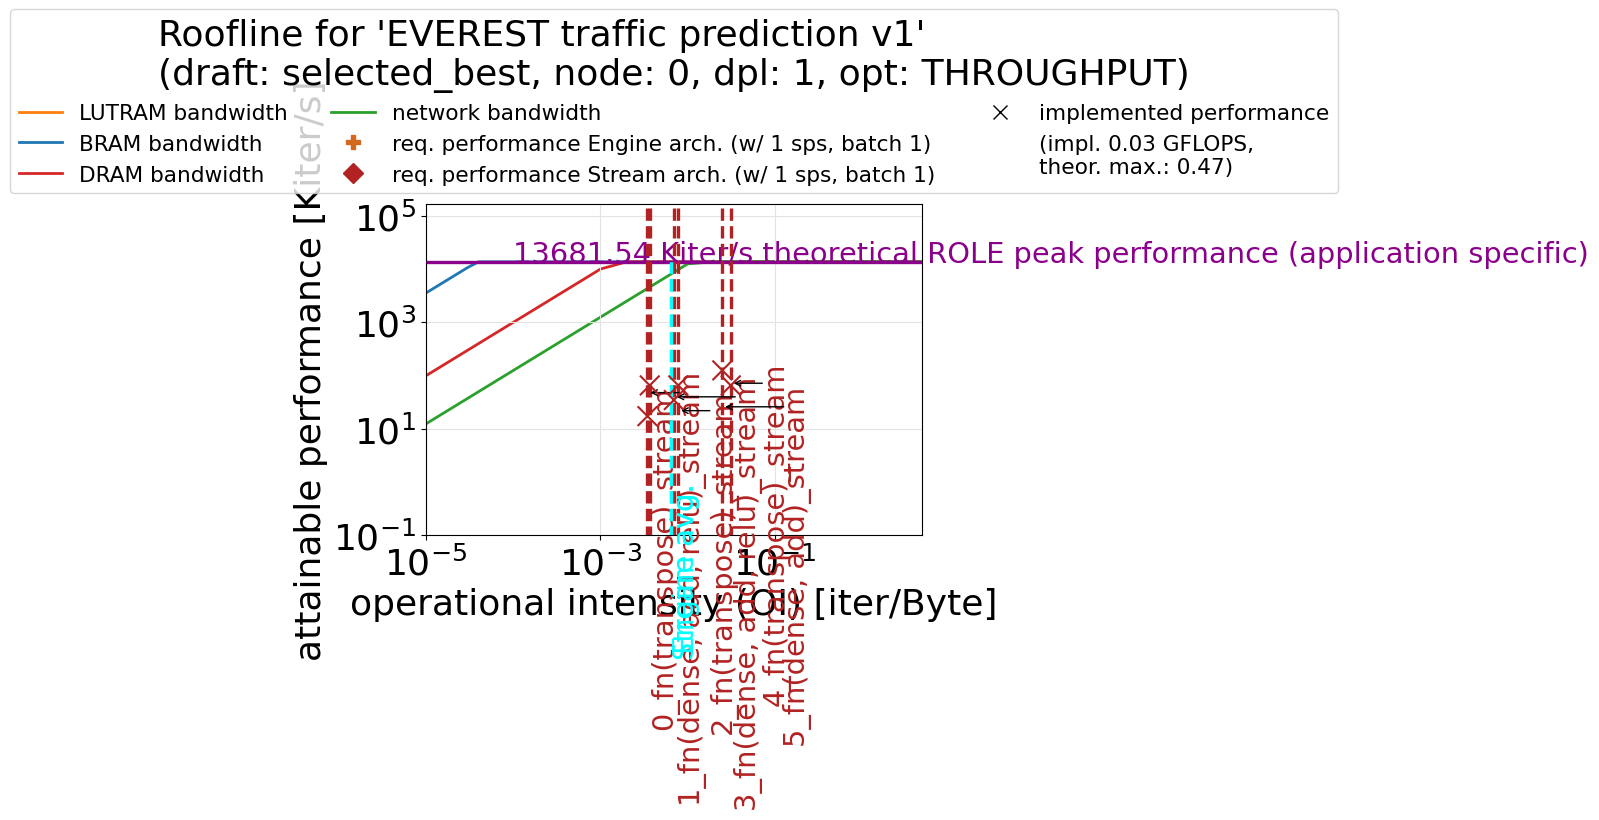

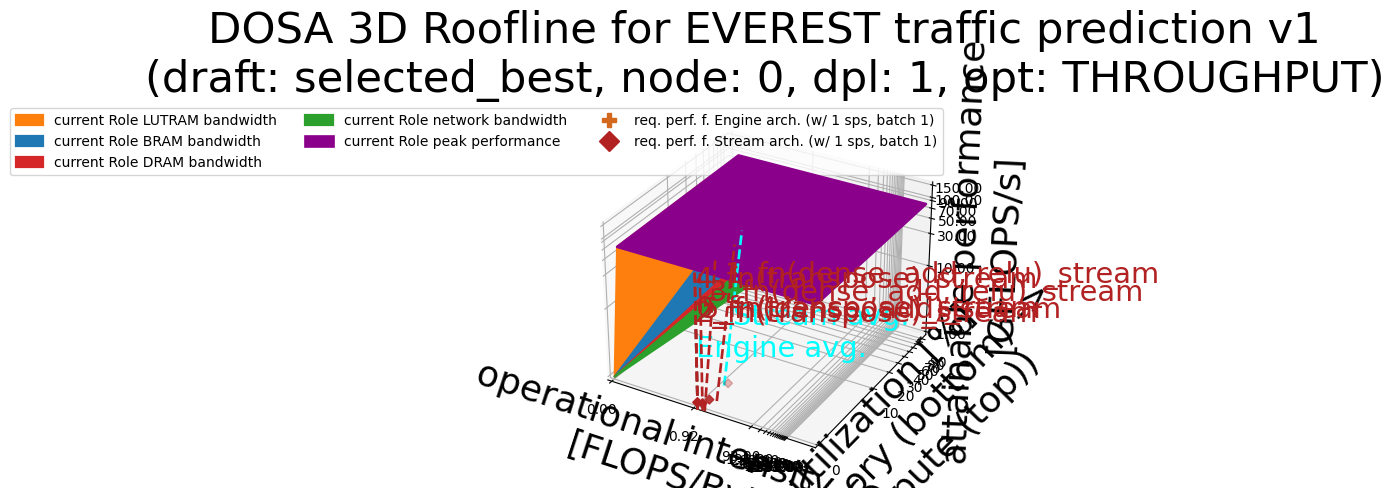

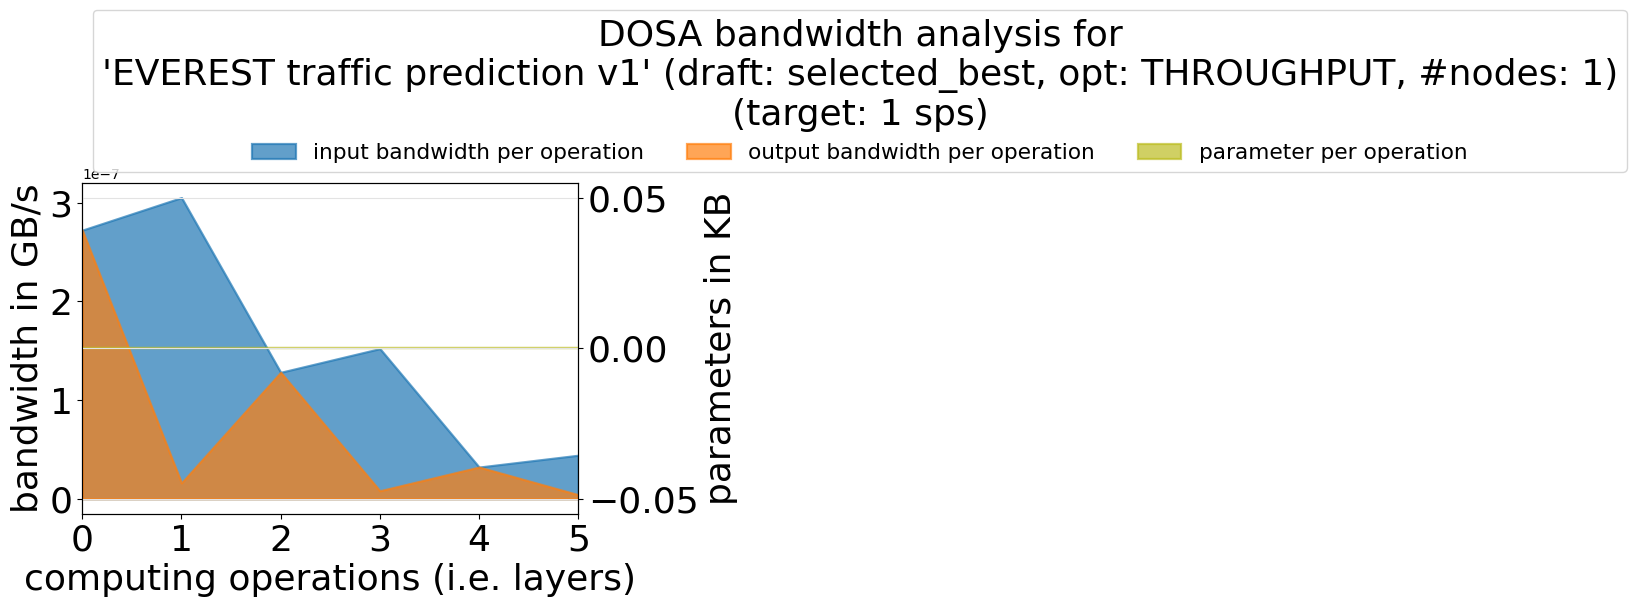

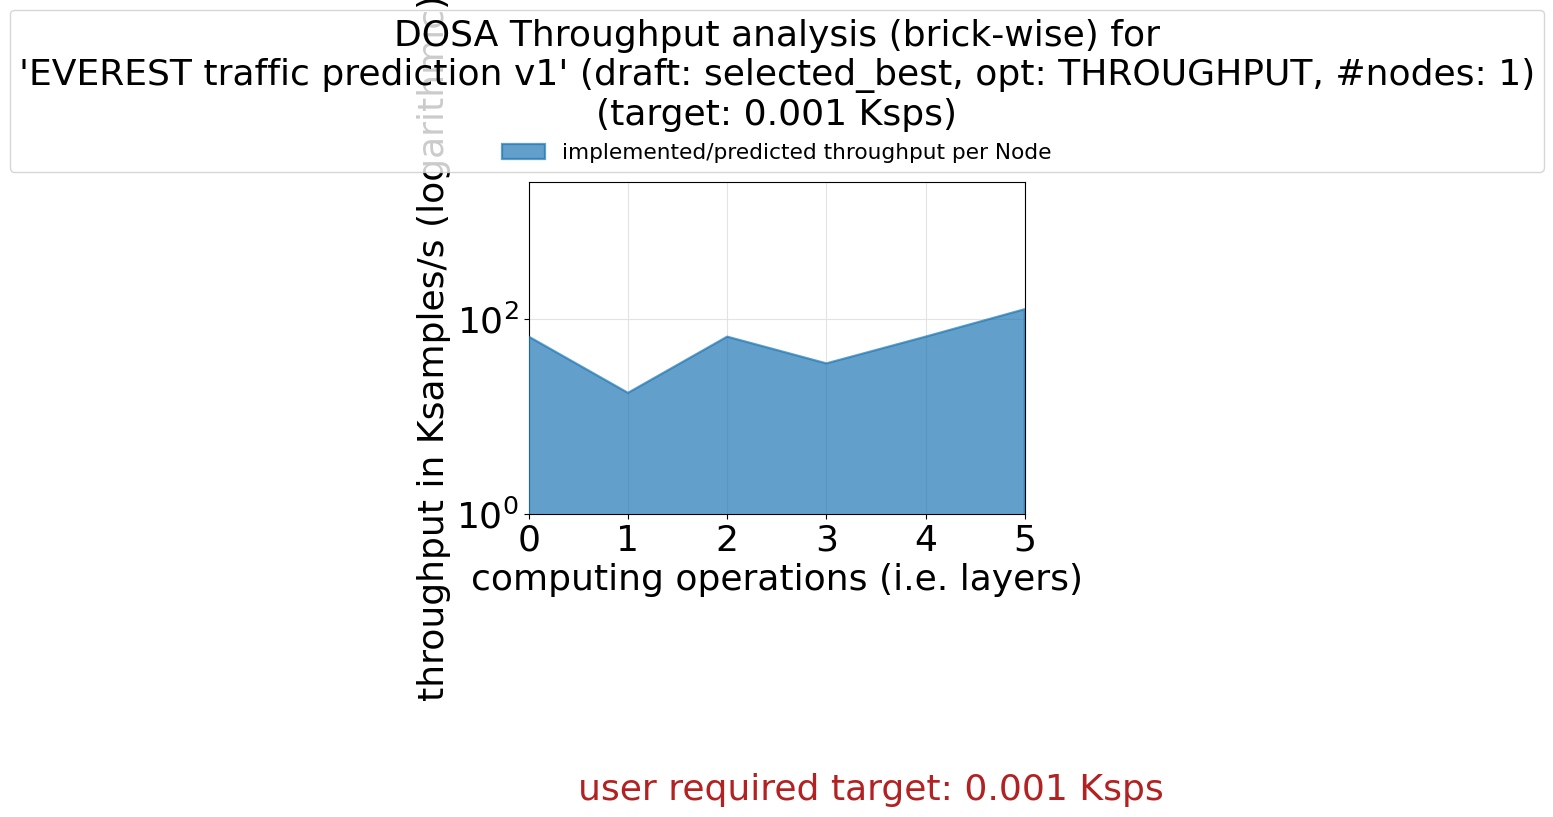

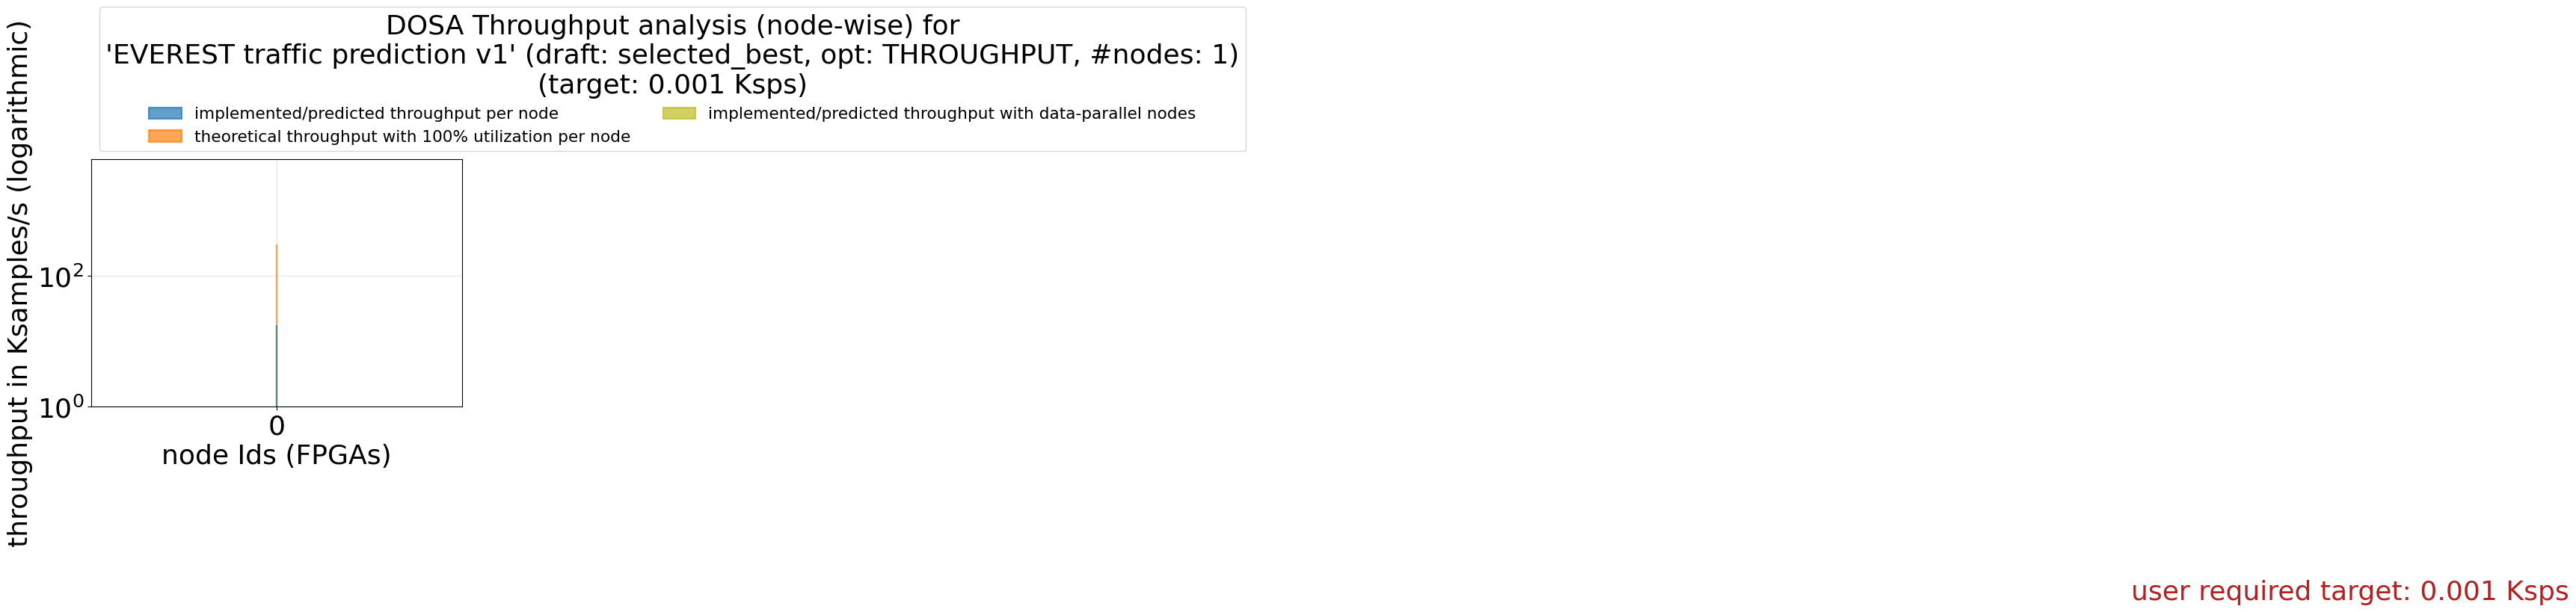

[DOSA:roofline] Hit [enter] to close roofline plots. 


	...done.


DOSA finished successfully.



In [7]:
emli.disable_build = True
emli.compile()

Performance Engineer part
----------------------------
As described in the user story, the performance engineer could modify global or high-level configuration of DOSA to accomodate applicaiton specific architectural trade-offs. This would require a re-compilation of the application. 

In [8]:
emli.dosa_config['build']['comm_message_interleaving'] = 5
# emli.dosa_config['quantization_thresholding_feature']....

Workflow Engineer part
-------------------------

Now, the workflow engineer could take over to create a container and deploy the corresponding workflow (including annotated dependencies). This is shown in the notebook 04. 

Application deployment
-------------------------------
The output of DOSA needs to be (partially) built, i.e. generating the FPGA bitstreams. Then, depending on skills and the application context, further specialists for performance, workflow, or infrastructure need to define the deployment process. 
However, DOSA also generates a `dosa_deploy.py` to be able to deploy all required FPGAs (for some FPGA platforms, e.g. IBM cloudFPGA). Also DOSA generates python and c++ wrappers to be used by the application or by the variation combination. 
How different (accelerated) variants of an application could be combined and executed is shown in notebook 02.